# Provenance & License

**Source notebook:** `SB3_a2c_quanstats.ipynb`  
**Upstream project:** [gym-anytrading](https://github.com/AminHP/gym-anytrading)  
**Original author:** Amin HP  
**License:** MIT License (see upstream repository)

**Adapted by:** Chunlin Feng — 2025-09-19

**Changes:**
- 

**Link to source:**  
https://github.com/AminHP/gym-anytrading/blob/master/examples/SB3_a2c_quantstats.ipynb 


### Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions

from stable_baselines3 import A2C


In [2]:
train = pd.read_csv('../data/train_data.csv')
trade = pd.read_csv('../data/trade_data.csv')
train_aapl = train[train["tic"] == "AAPL"]
train_gym_anytrade = pd.DataFrame()
train_gym_anytrade['Time'] = pd.to_datetime(train_aapl['date'])  # Convert to datetime
train_gym_anytrade['Open'] = train_aapl['open']
train_gym_anytrade['High'] = train_aapl['high']
train_gym_anytrade['Low'] = train_aapl['low']
train_gym_anytrade['Close'] = train_aapl['close']
train_gym_anytrade['Volume'] = train_aapl['volume']
train_gym_anytrade


trade_aapl = trade[trade["tic"] == "AAPL"]
trade_gym_anytrade = pd.DataFrame()
trade_gym_anytrade['Time'] = pd.to_datetime(trade_aapl['date'])  # Convert to datetime
trade_gym_anytrade['Open'] = trade_aapl['open']
trade_gym_anytrade['High'] = trade_aapl['high']
trade_gym_anytrade['Low'] = trade_aapl['low']
trade_gym_anytrade['Close'] = trade_aapl['close']
trade_gym_anytrade['Volume'] = trade_aapl['volume']

### Create Env

In [3]:
env_name = 'stocks-v0'

window_size = 30
start_index = window_size

env_train = gym.make(
    env_name,
    df=train_gym_anytrade,
    window_size=window_size,
    frame_bound=(window_size, len(train_gym_anytrade))
)

env_trade = gym.make(
    env_name,
    df=trade_gym_anytrade,
    window_size=window_size,
    frame_bound=(window_size, len(trade_gym_anytrade))
)

### Train Env

In [ ]:
env_train.reset()
model = A2C('MlpPolicy', env_train, verbose=0)
model.learn(total_timesteps=1_00000)

/home/feng/CS/testenv/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


### Test Env

In [5]:
action_stats = {Actions.Sell: 0, Actions.Buy: 0}

observation, info = env_trade.reset(seed=2023)

while True:
    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    action_stats[Actions(action)] += 1
    observation, reward, terminated, truncated, info = env_trade.step(action)
    done = terminated or truncated

    # env.render()
    if done:
        break

env_trade.close()

print("action_stats:", action_stats)
print("info:", info)

action_stats: {<Actions.Sell: 0>: 166, <Actions.Buy: 1>: 303}
info: {'total_reward': np.float32(57.893814), 'total_profit': np.float32(0.24000454), 'position': <Positions.Long: 1>}


### Plot Results

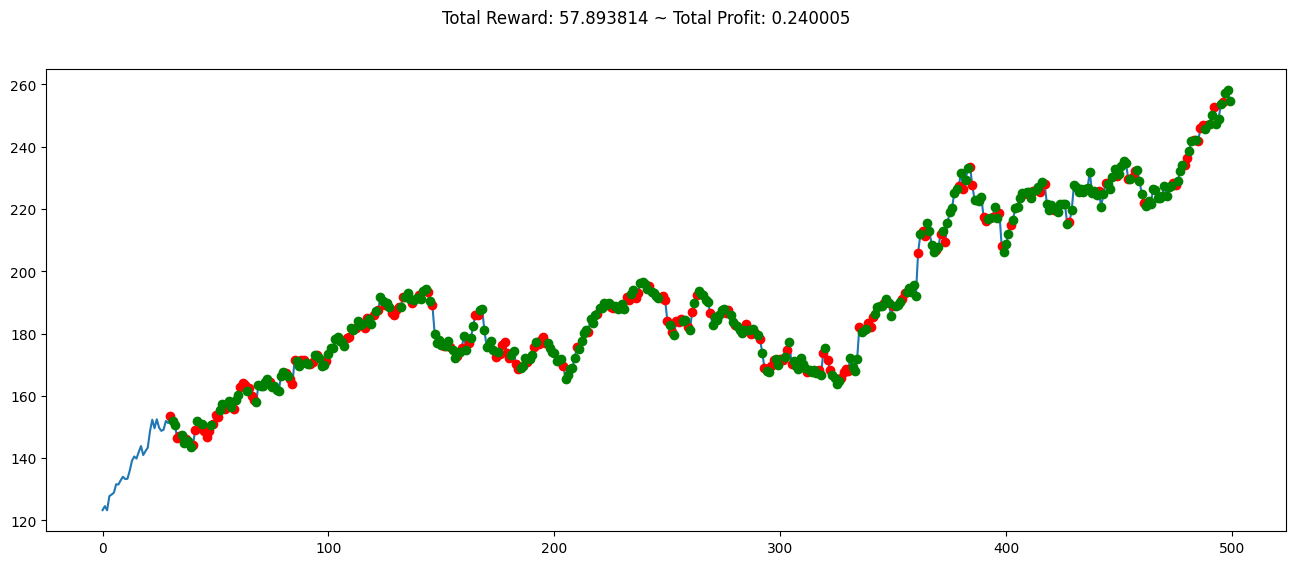

In [6]:
plt.figure(figsize=(16, 6))
env_trade.unwrapped.render_all()
plt.show()

In [ ]:
def align_and_export_episode(env_trade, trade_df, time_col="Time", skip=30, out_path="./results/Gym_anytrade.csv"):
    uw = env_trade.unwrapped

    start, end = uw._start_tick, uw._current_tick
    if end < start:
        raise ValueError(f"Invalid tick range: start={start}, end={end}")
    ep_len = end - start + 1

    index = uw.df.index[start:end+1] if hasattr(uw.df, "index") else np.arange(start, end + 1)

    pos_series = [
        None if p is None else getattr(p, "name", str(p))
        for p in uw._position_history[start:end+1]
    ]

    hist = uw.history or {}

    def get_hist(key):
        vals = list(hist.get(key, []))
        if len(vals) < ep_len:
            vals += [np.nan] * (ep_len - len(vals))
        return vals[:ep_len]

    df_ep = pd.DataFrame({
        "price":        uw.prices[start:end+1],
        "position":     pos_series,
        "total_reward": get_hist("total_reward"),
        "total_profit": get_hist("total_profit"),
        "daily_return": get_hist("daily_return"),
    }, index=index)

    if time_col not in trade_df.columns:
        raise KeyError(f"Column '{time_col}' not found in trade_df.")
    dates = pd.to_datetime(trade_df[time_col])

    date_idx = dates.iloc[skip: skip + len(df_ep)].reset_index(drop=True)
    df_ep_aligned = df_ep.reset_index(drop=True).copy()

    if len(date_idx) != len(df_ep_aligned):
        raise ValueError(
            f"Length mismatch: {len(date_idx)} dates vs {len(df_ep_aligned)} df_ep rows. "
            f"Adjust `skip` or verify episode length."
        )

    df_ep_aligned.index = date_idx
    df_ep_aligned.index.name = "Date"
    df_ep_aligned.to_csv(out_path)
    return df_ep_aligned


df_aligned = align_and_export_episode(env_trade, trade_gym_anytrade, time_col="Time", skip=30, out_path="./results/Gym_anytrade.csv")
df_aligned

,price,position,total_reward,total_profit,daily_return
Date,,,,,
2023-02-15,153.403687,Short,0.000000,1.000000,NaN
2023-02-16,151.803787,Long,0.000000,1.000000,NaN
2023-02-17,150.658173,Long,-5.165146,0.951534,NaN
2023-02-21,146.638641,Short,-5.165146,0.951534,NaN
2023-02-22,147.063293,Short,-5.165146,0.951534,NaN
...,...,...,...,...,...
2024-12-20,253.589767,Long,57.893814,0.246135,NaN
2024-12-23,254.367004,Short,57.893814,0.246135,NaN
2024-12-24,257.286682,Long,57.893814,0.246135,NaN
